# Import necessary libraries

In [19]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [35]:
sales_df = pd.read_csv('../examples/retail_sales.csv', index_col='date', parse_dates=True)

In [36]:
sales_df.head()

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [37]:
df = sales_df.reset_index()

In [38]:
df.head()

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [39]:
df=df.rename(columns={'date':'ds', 'sales':'y'})

In [40]:
df.head()

,ds,y
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

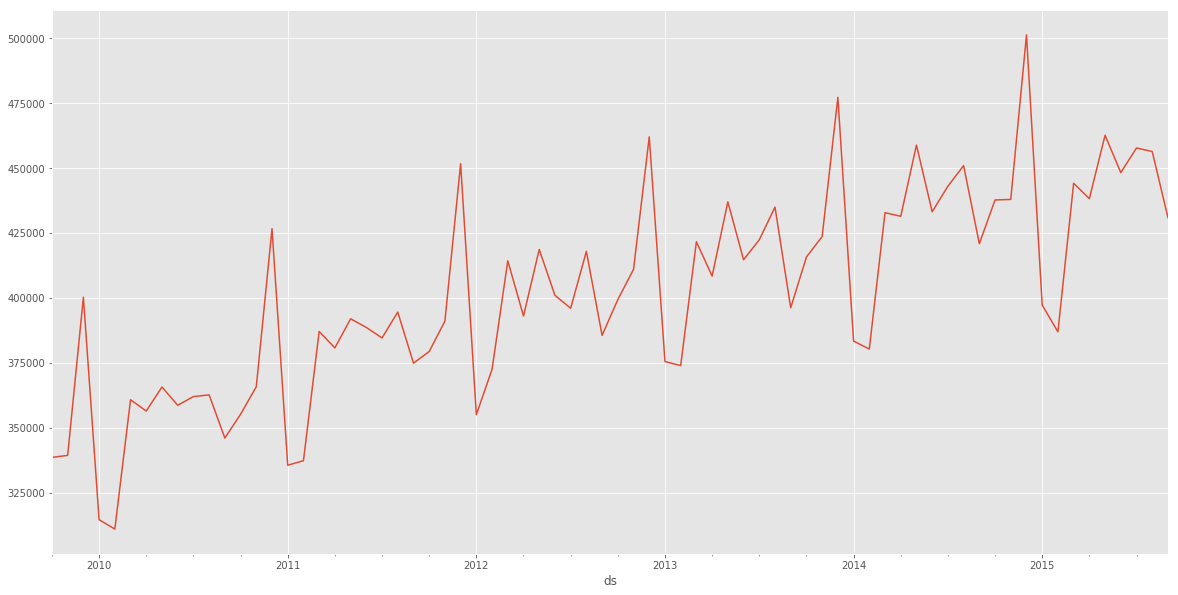

In [41]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now.  Taking the log of a number is easily reversible to be able to see your original data. 

To log-transform your data, you can use numpy's log() function

In [42]:
df['y'] = np.log(df['y'])

In [70]:
df.tail()

,ds,y
67,2015-05-01,13.044650
68,2015-06-01,13.013060
69,2015-07-01,13.033991
70,2015-08-01,13.030993
71,2015-09-01,12.973671


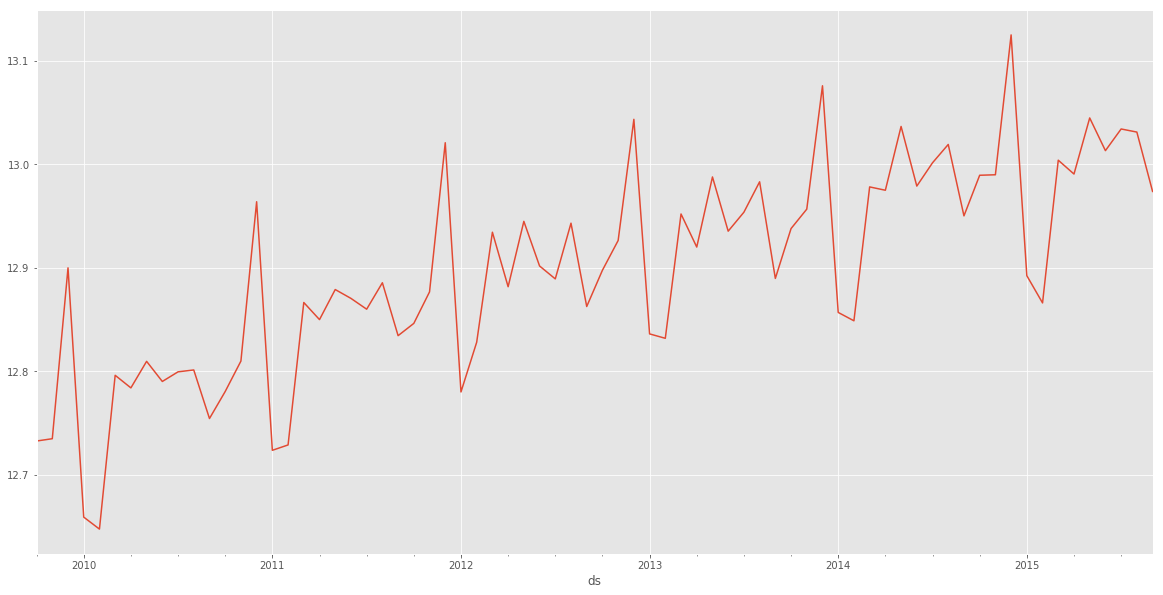

In [44]:
df.set_index('ds').y.plot()

As you can see in the above chart, the plot looks the same as the first one but just at a different scale.

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [61]:
model = Prophet()
model.fit(df);

Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the ```freq='m'``` inclusion to ensure we are adding 24 months of data.

This can be done with the following code:


In [78]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
91,2017-04-30
92,2017-05-31
93,2017-06-30
94,2017-07-31
95,2017-08-31


To forecast this future data, we need to run it through Prophet's model.

In [79]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [80]:
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
91,2017-04-30,1.280888,13.042878,0.020710,0.020710,12.921649,13.159989,12.942295,13.181245,0.020710,0.020710,0.020710,0.020710,13.063588
92,2017-05-31,1.295234,13.044540,0.011932,0.011932,12.913173,13.169840,12.928387,13.184109,0.011932,0.011932,0.011932,0.011932,13.056472
93,2017-06-30,1.309116,13.046148,0.028827,0.028827,12.904600,13.180931,12.936901,13.210673,0.028827,0.028827,0.028827,0.028827,13.074975
94,2017-07-31,1.323461,13.047810,0.003016,0.003016,12.897572,13.192731,12.899459,13.197185,0.003016,0.003016,0.003016,0.003016,13.050825
95,2017-08-31,1.337807,13.049471,-0.025674,-0.025674,12.888015,13.202298,12.861562,13.178651,-0.025674,-0.025674,-0.025674,-0.025674,13.023797


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [81]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2017-04-30,13.063588,12.942295,13.181245
92,2017-05-31,13.056472,12.928387,13.184109
93,2017-06-30,13.074975,12.936901,13.210673
94,2017-07-31,13.050825,12.899459,13.197185
95,2017-08-31,13.023797,12.861562,13.178651


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

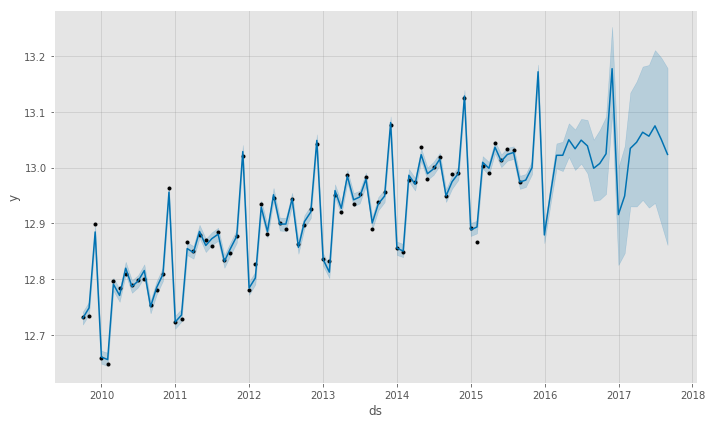

In [84]:
model.plot(forecast);

Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself.  The next section describes how I build my own visualization for Prophet modeling 

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data